In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import colour
import matplotlib.pyplot as plt

import random

In [2]:
from debayering.datasets.raw_dataset import RawLoader

raw_shape = colour.io.read_image('data/dataset/input/1.png').shape
raw_shape = (int(raw_shape[0] / 2), int(raw_shape[1] / 2))

print(raw_shape)

base_dir = "data/dataset"
train_input_dir = os.path.join(base_dir, "input")
train_target_dir = os.path.join(base_dir, "groundtruth")
img_size = raw_shape
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
val_samples = 8
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = RawLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = RawLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(train_gen))
print("Number val batches:", len(val_gen))

(105, 159)
1.png | 1.png
10.png | 10.png
11.png | 11.png
12.png | 12.png
13.png | 13.png
14.png | 14.png
15.png | 15.png
16.png | 16.png
17.png | 17.png
18.png | 18.png
Number of samples: 57
Number train batches: 6
Number val batches: 1


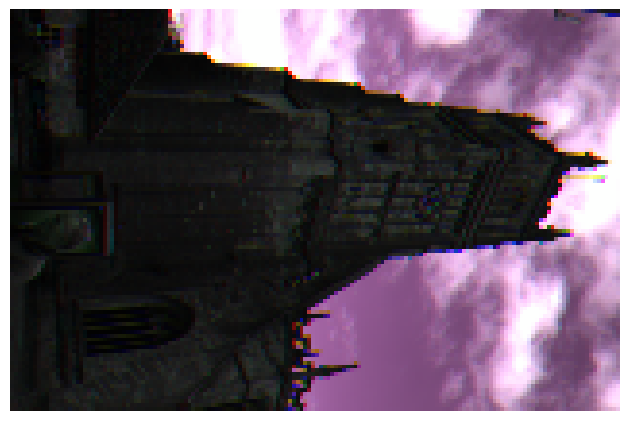

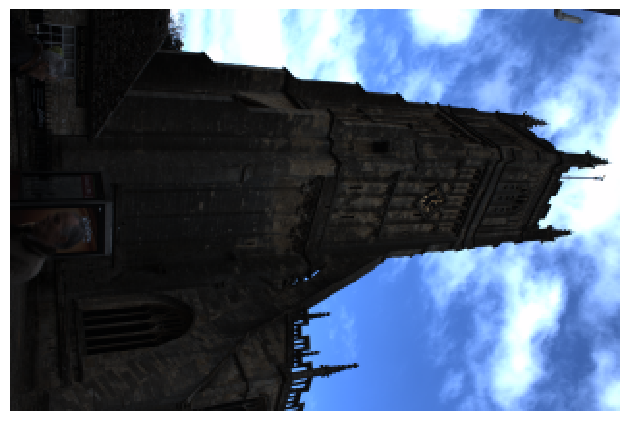

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [3]:
x, y = train_gen.__getitem__(0)
colour.plotting.plot_image(x[0][:,:,1:4])
colour.plotting.plot_image(y[0])

In [22]:
def main_loss(y_true, y_pred):
    return tf.abs(y_true - y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [23]:
from debayering.models import simple_conv

simple_conv_model = simple_conv.get_model()
simple_conv_model.compile(optimizer='adam', loss=main_loss, metrics=[ssim, psnr])
simple_conv_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 4)]   0         
                                                                 
 conv2d_47 (Conv2D)          (None, None, None, 16)    592       
                                                                 
 conv2d_48 (Conv2D)          (None, None, None, 16)    2320      
                                                                 
 conv2d_49 (Conv2D)          (None, None, None, 12)    1740      
                                                                 
 tf.nn.depth_to_space_1 (TFO  (None, None, None, 3)    0         
 pLambda)                                                        
                                                                 
Total params: 4,652
Trainable params: 4,652
Non-trainable params: 0
_________________________________________________________

In [24]:
epochs = 20

history = simple_conv_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=val_gen, 
    workers=8
)

Epoch 1/20
6/6 [==============================] - 3s 355ms/step - loss: 0.1177 - ssim: 0.2936 - psnr: 14.9886 - val_loss: 0.1123 - val_ssim: 0.3248 - val_psnr: 15.8849
Epoch 2/20
6/6 [==============================] - 2s 271ms/step - loss: 0.0994 - ssim: 0.3464 - psnr: 15.9844 - val_loss: 0.0896 - val_ssim: 0.4396 - val_psnr: 17.4689
Epoch 3/20
6/6 [==============================] - 2s 309ms/step - loss: 0.0757 - ssim: 0.4263 - psnr: 17.9081 - val_loss: 0.0639 - val_ssim: 0.4747 - val_psnr: 19.6378
Epoch 4/20
6/6 [==============================] - 2s 316ms/step - loss: 0.0624 - ssim: 0.4644 - psnr: 19.1413 - val_loss: 0.0536 - val_ssim: 0.5565 - val_psnr: 20.5923
Epoch 5/20
6/6 [==============================] - 2s 307ms/step - loss: 0.0546 - ssim: 0.5341 - psnr: 20.2581 - val_loss: 0.0453 - val_ssim: 0.6123 - val_psnr: 22.5232
Epoch 6/20
6/6 [==============================] - 2s 266ms/step - loss: 0.0454 - ssim: 0.5952 - psnr: 22.4175 - val_loss: 0.0329 - val_ssim: 0.6905 - val_psnr: 

1/1 [==============================] - 0s 119ms/step


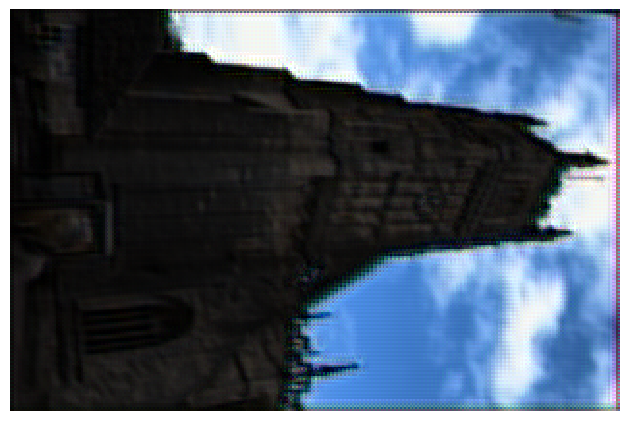

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [25]:
simple_conv_model.evaluate(val_gen)
pred = simple_conv_model.predict(x)
colour.plotting.plot_image(pred[0])

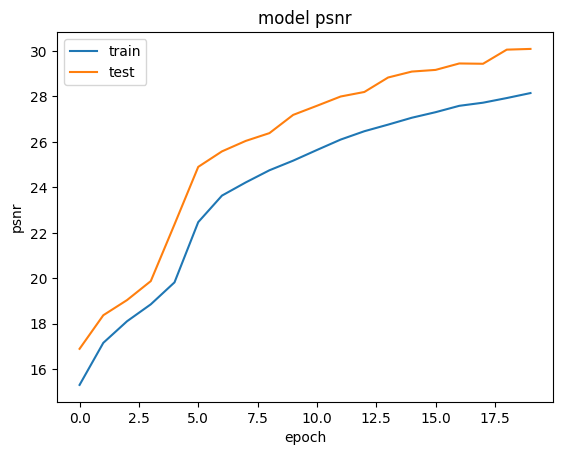

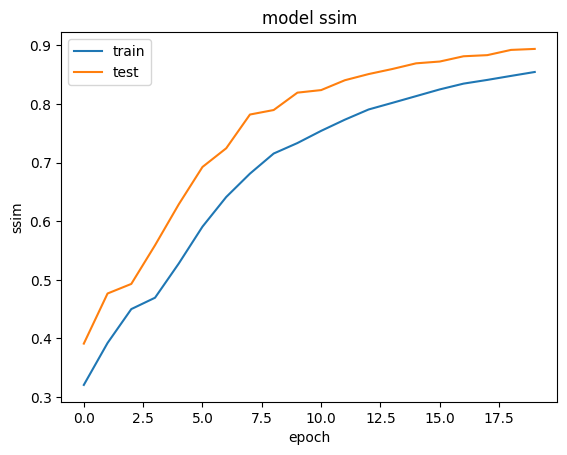

In [14]:
# summarize history for psnr
plt.plot(history.history['psnr'])
plt.plot(history.history['val_psnr'])
plt.title('model psnr')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for ssim
plt.plot(history.history['ssim'])
plt.plot(history.history['val_ssim'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
from debayering.models import unet

unet_model = unet.get_model()
unet_model.compile(optimizer='adam', loss=main_loss, metrics=[ssim, psnr])
unet_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv2d_50 (Conv2D)             (None, None, None,   296         ['input_8[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_51 (Conv2D)             (None, None, None,   584         ['conv2d_50[0][0]']              
                                8)                                                          

In [29]:
epochs = 10

history = unet_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=val_gen, 
    workers=8
)

Epoch 1/10
6/6 [==============================] - 4s 606ms/step - loss: 0.0326 - ssim: 0.7678 - psnr: 25.4640 - val_loss: 0.0275 - val_ssim: 0.8449 - val_psnr: 26.6681
Epoch 2/10
6/6 [==============================] - 4s 656ms/step - loss: 0.0318 - ssim: 0.7833 - psnr: 25.5497 - val_loss: 0.0273 - val_ssim: 0.8507 - val_psnr: 26.6425
Epoch 3/10
6/6 [==============================] - 4s 665ms/step - loss: 0.0311 - ssim: 0.7910 - psnr: 25.6960 - val_loss: 0.0260 - val_ssim: 0.8569 - val_psnr: 27.0420
Epoch 4/10
6/6 [==============================] - 4s 625ms/step - loss: 0.0302 - ssim: 0.8013 - psnr: 26.0036 - val_loss: 0.0261 - val_ssim: 0.8587 - val_psnr: 27.0971
Epoch 5/10
6/6 [==============================] - 4s 601ms/step - loss: 0.0296 - ssim: 0.8095 - psnr: 26.0802 - val_loss: 0.0275 - val_ssim: 0.8654 - val_psnr: 26.8880
Epoch 6/10
6/6 [==============================] - 4s 627ms/step - loss: 0.0297 - ssim: 0.8167 - psnr: 26.1158 - val_loss: 0.0258 - val_ssim: 0.8642 - val_psnr: 

1/1 [==============================] - 0s 44ms/step


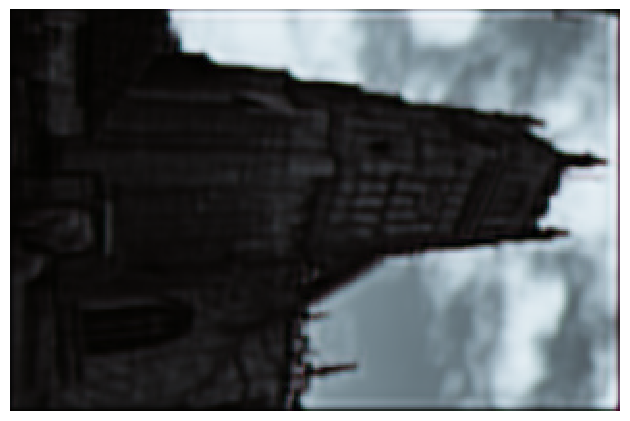

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [30]:
pred = unet_model.predict(x)
colour.plotting.plot_image(pred[0])

In [17]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, 
    Convolution2D,
)


def get_model(input_shape=(None, None, 4)): 
    inputs = Input(shape=input_shape)

    conv1 = Convolution2D(16, (3, 3), activation='tanh', padding='same')(inputs)
    conv2 = Convolution2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv3 = Convolution2D(12, (3, 3), activation='relu', padding='same')(conv2)
    x_out = tf.nn.depth_to_space(conv3, 2)
    return Model(inputs=inputs, outputs=x_out)

In [18]:
model = get_model()
model.compile(optimizer='adam', loss='mae', metrics=[ssim, psnr])
epochs = 10

history = unet_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=val_gen, 
    workers=8
)

Epoch 1/10
6/6 [==============================] - 4s 602ms/step - loss: 0.0219 - ssim: 0.8503 - psnr: 28.1952 - val_loss: 0.0185 - val_ssim: 0.8925 - val_psnr: 29.6772
Epoch 2/10
6/6 [==============================] - 4s 614ms/step - loss: 0.0224 - ssim: 0.8562 - psnr: 28.0867 - val_loss: 0.0174 - val_ssim: 0.8979 - val_psnr: 30.1401
Epoch 3/10
6/6 [==============================] - 4s 602ms/step - loss: 0.0219 - ssim: 0.8573 - psnr: 28.1812 - val_loss: 0.0178 - val_ssim: 0.8977 - val_psnr: 30.1573
Epoch 4/10
6/6 [==============================] - 4s 595ms/step - loss: 0.0222 - ssim: 0.8547 - psnr: 28.3081 - val_loss: 0.0187 - val_ssim: 0.8800 - val_psnr: 29.9870
Epoch 5/10
6/6 [==============================] - 4s 634ms/step - loss: 0.0216 - ssim: 0.8587 - psnr: 28.4557 - val_loss: 0.0164 - val_ssim: 0.9001 - val_psnr: 30.4712
Epoch 6/10
6/6 [==============================] - 4s 661ms/step - loss: 0.0212 - ssim: 0.8621 - psnr: 28.5085 - val_loss: 0.0167 - val_ssim: 0.9019 - val_psnr: 

1/1 [==============================] - 0s 71ms/step


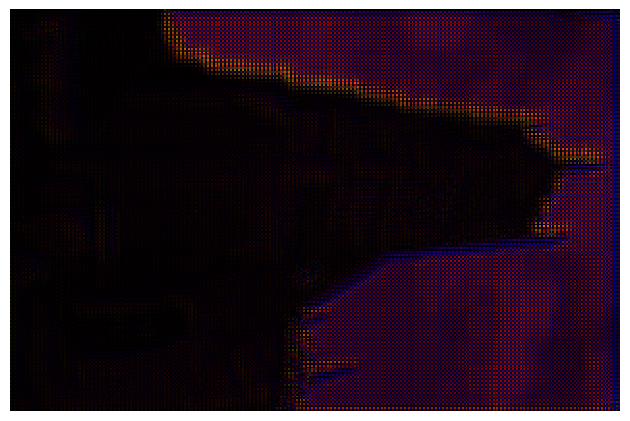

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [19]:
pred = model.predict(x)
colour.plotting.plot_image(pred[0])